<a href="https://www.kaggle.com/code/nalamotse/brain-tumor-detection-cnn-classifier?scriptVersionId=236611595" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

2025-04-28 12:13:00.931509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745842381.185640      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745842381.254707      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Yes_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'
No_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'


print(os.listdir(Yes_path))
print(os.listdir(No_path))

['Y115.JPG', 'Y192.JPG', 'Y162.jpg', 'Y9.jpg', 'Y108.jpg', 'Y155.JPG', 'Y106.jpg', 'Y258.JPG', 'Y103.jpg', 'Y185.jpg', 'Y180.jpg', 'Y120.JPG', 'Y54.jpg', 'Y165.JPG', 'Y112.JPG', 'Y99.JPG', 'Y3.jpg', 'Y184.JPG', 'Y82.jpg', 'Y169.jpg', 'Y146.JPG', 'Y147.JPG', 'Y116.JPG', 'Y27.jpg', 'Y73.jpg', 'Y181.jpg', 'Y81.jpg', 'Y161.JPG', 'Y17.jpg', 'Y69.jpg', 'Y158.JPG', 'Y32.jpg', 'Y186.jpg', 'Y259.JPG', 'Y42.jpg', 'Y250.jpg', 'Y58.JPG', 'Y60.jpg', 'Y252.jpg', 'Y182.JPG', 'Y154.jpg', 'Y79.jpg', 'Y31.jpg', 'Y98.JPG', 'Y91.jpg', 'Y95.jpg', 'Y22.jpg', 'Y35.jpg', 'Y33.jpg', 'Y247.JPG', 'Y19.JPG', 'Y160.JPG', 'Y13.jpg', 'Y29.jpg', 'Y55.jpg', 'Y4.jpg', 'Y50.JPG', 'Y114.JPG', 'Y26.jpg', 'Y257.jpg', 'Y97.JPG', 'Y14.jpg', 'Y25.jpg', 'Y170.JPG', 'Y51.jpg', 'Y34.jpg', 'Y39.jpg', 'Y15.jpg', 'Y104.jpg', 'Y187.jpg', 'Y167.JPG', 'Y40.JPG', 'Y38.jpg', 'Y111.JPG', 'Y37.jpg', 'Y24.jpg', 'Y157.JPG', 'Y6.jpg', 'Y28.jpg', 'Y164.JPG', 'Y30.jpg', 'Y90.jpg', 'Y92.jpg', 'Y86.JPG', 'Y46.jpg', 'Y248.JPG', 'Y1.jpg', 'Y2.jpg'

In [3]:
IMG_SIZE = 64
data = []
labels = []

def ImagesLoading(path, label):
    for image in os.listdir(path):
        if image.lower().endswith(('.jpg', '.jpeg')):
            full_path = os.path.join(path, image)
            img = cv2.imread(full_path, cv2.IMREAD_COLOR)  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0 
            data.append(img)
            labels.append(label)

ImagesLoading(Yes_path, label=1)
ImagesLoading(No_path, label=0)


In [4]:
# data

In [5]:
unique, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")


Label 0: 97 samples
Label 1: 154 samples


In [6]:
data = np.array(data).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
labels = np.array(labels)
data, labels = shuffle(data, labels, random_state=42)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (200, 64, 64, 3) (200,)
Test: (51, 64, 64, 3) (51,)


In [8]:
print(Counter(y_train))
print(Counter(y_test))


Counter({1: 122, 0: 78})
Counter({1: 32, 0: 19})


In [9]:
datagen = ImageDataGenerator( rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
datagen.fit(X_train)
model = Sequential([
    Conv2D(128, (5,5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(128, (5,5), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (5,5), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Conv2D(32, (3,3), activation='relu'),
    # MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
# opt = Adam(learning_rate=0.000006)  
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.000006,
    decay_steps=200,       
    decay_rate=0.99,       
    staircase=True        
)
opt = Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), validation_data=(X_test, y_test), epochs=200)#, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-28 12:13:19.620266: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6127 - loss: 0.6887 - val_accuracy: 0.6275 - val_loss: 0.6874
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6311 - loss: 0.6862 - val_accuracy: 0.6275 - val_loss: 0.6860
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6532 - loss: 0.6844 - val_accuracy: 0.6275 - val_loss: 0.6848
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5853 - loss: 0.6863 - val_accuracy: 0.6275 - val_loss: 0.6837
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6138 - loss: 0.6840 - val_accuracy: 0.6275 - val_loss: 0.6824
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5912 - loss: 0.6839 - val_accuracy: 0.6275 - val_loss: 0.6812
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5928 - loss: 0.6823 - val_accuracy: 0.6275 - val_loss: 0.6798
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6086 - loss: 0.6793 - val_accuracy: 0.6275 - val_loss: 0.6784
Epoch 9/200
4/4 ━━

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Loss: {train_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7729 - loss: 0.5132
Test Accuracy: 0.7843
Test Loss: 0.5142
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.7602 - loss: 0.5294
Train Accuracy: 0.8050
Train Loss: 0.4915


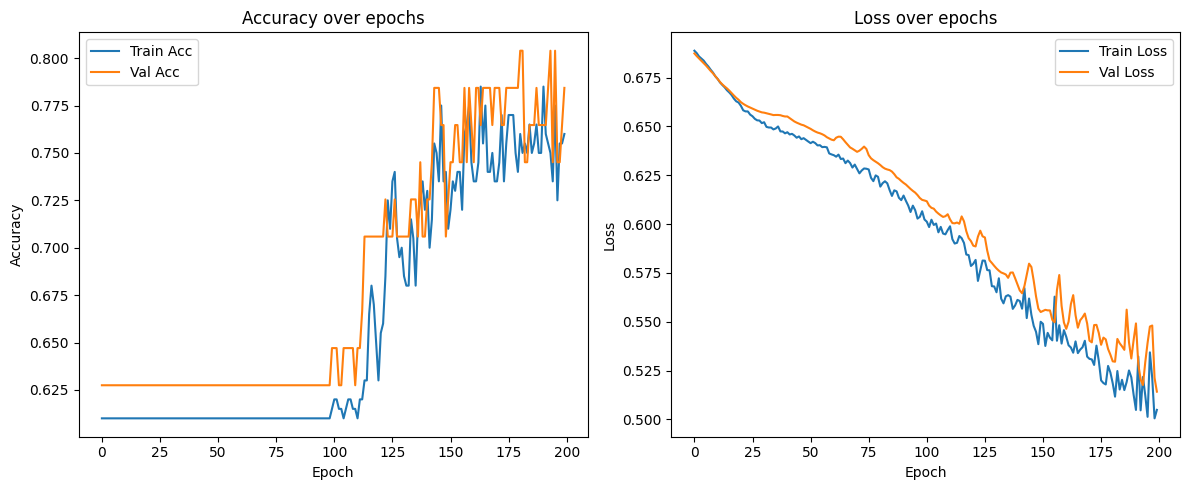

In [11]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

print(classification_report(y_test, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
              precision    recall  f1-score   support

           0       0.79      0.58      0.67        19
           1       0.78      0.91      0.84        32

    accuracy                           0.78        51
   macro avg       0.78      0.74      0.75        51
weighted avg       0.78      0.78      0.78        51



In [13]:
y_predTrain_probs = model.predict(X_train)
y_predTrain = (y_predTrain_probs > 0.5).astype("int32")

print(classification_report(y_train, y_predTrain))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
              precision    recall  f1-score   support

           0       0.75      0.74      0.75        78
           1       0.84      0.84      0.84       122

    accuracy                           0.81       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.81      0.80       200



In [14]:
roc_auc_score(y_test, model.predict(X_test))
roc_auc_score(y_train, model.predict(X_train))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


0.8594997898276586

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


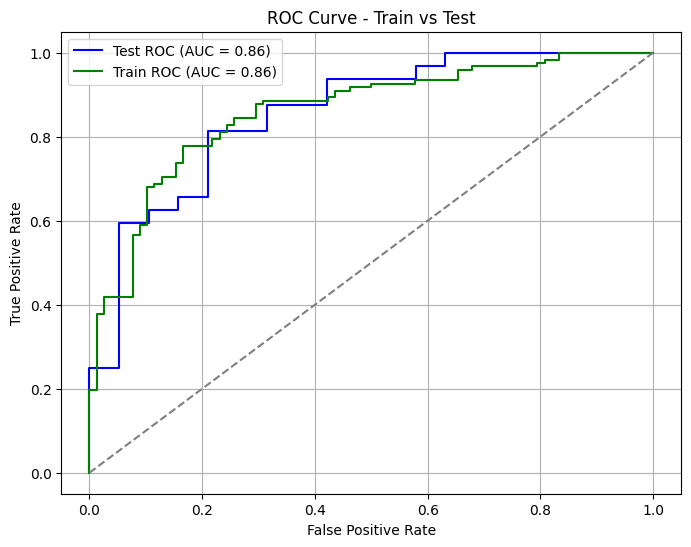

In [15]:
# Get predicted probabilities (not class labels!)
y_test_probs = model.predict(X_test)
y_train_probs = model.predict(X_train)

# Compute ROC curve and AUC for test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

# Compute ROC curve and AUC for train
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
auc_train = roc_auc_score(y_train, y_train_probs)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.2f})', color='blue')
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.2f})', color='green')

# Reference line for random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train vs Test')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
model.save("TumorPredictionCNN_model.h5")
# from tensorflow.keras.models import load_model
# model = load_model("my_cnn_model.h5")
